## Importing libraries 

In [3]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import timedelta
import os

## path

In [7]:
stock_folder = "../Data/yfinance_data"
news_csv = "../Data/newsData/analyst_ratings.csv"
output_folder = "./output"
os.makedirs(output_folder, exist_ok=True)

pd.options.display.max_columns = 200
sns.set_style('whitegrid')

## load stock files 

In [8]:
# Load stock data files for the tickers you listed
tickers = {
    'AAPL': 'AAPL.csv',
    'AMZN': 'AMZN.csv',
    'GOOG': 'GOOG.csv',
    'META': 'META.csv',
    'MSFT': 'MSFT.csv',
    'NVDA': 'NVDA.csv'
}

stocks = {}
for t, fname in tickers.items():
    path = os.path.join(stock_folder, fname)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Expected stock file not found: {path}")
    df = pd.read_csv(path, parse_dates=['Date'])
    # Normalize column names (strip spaces)
    df.columns = [c.strip() for c in df.columns]
    df = df.sort_values('Date').reset_index(drop=True)
    # compute daily returns (simple) and log returns
    df['Return'] = df['Close'].pct_change()
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Ticker'] = t
    stocks[t] = df

# Quick check
for t in stocks:
    print(t, stocks[t].shape)


AAPL (3774, 9)
AMZN (3774, 9)
GOOG (3774, 9)
META (2923, 9)
MSFT (3774, 9)
NVDA (3774, 9)


## Load news CSV and parse dates

In [12]:
# Load news CSV (raw analyst ratings)
news = pd.read_csv(news_csv)
# Trim column names; some inputs may have a leading comma
news.columns = [c.strip() for c in news.columns]
# Lowercase columns for robustness
news.columns = [c.lower() for c in news.columns]

expected = {'headline', 'url', 'publisher', 'date', 'stock'}
present = set(news.columns)
missing = expected - present
if missing:
    print("Warning: missing expected columns (lowercase):", missing)
# Parse dates; allow time-of-day if present
news['date'] = pd.to_datetime(news['date'], errors='coerce')
# Use headline as text field; fill missing with empty string
news['headline'] = news.get('headline', '').fillna('')
print("News rows:", len(news))
news.head()


News rows: 1407328


,unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


## Compute sentiment: TextBlob + VADER

In [13]:
# Sentiment functions
analyzer = SentimentIntensityAnalyzer()

def textblob_polarity(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except Exception:
        return np.nan

def vader_compound(text):
    try:
        return analyzer.polarity_scores(str(text))['compound']
    except Exception:
        return np.nan

news['tb_polarity'] = news['headline'].apply(textblob_polarity)
news['vader_compound'] = news['headline'].apply(vader_compound)
# Ensemble score (simple average)
news['ensemble_score'] = 0.5 * news['vader_compound'] + 0.5 * news['tb_polarity']

# Labeling
def sentiment_label(score, pos_th=0.05, neg_th=-0.05):
    if score >= pos_th:
        return 'positive'
    elif score <= neg_th:
        return 'negative'
    else:
        return 'neutral'
news['sentiment_label'] = news['ensemble_score'].apply(sentiment_label)

news[['date','stock','headline','tb_polarity','vader_compound','ensemble_score','sentiment_label']].head(10)


,date,stock,headline,tb_polarity,vader_compound,ensemble_score,sentiment_label
0,2020-06-05 10:30:54-04:00,A,Stocks That Hit 52-Week Highs On Friday,0.00,0.000,0.000,neutral
1,2020-06-03 10:45:20-04:00,A,Stocks That Hit 52-Week Highs On Wednesday,0.00,0.000,0.000,neutral
2,2020-05-26 04:30:07-04:00,A,71 Biggest Movers From Friday,0.00,0.000,0.000,neutral
3,2020-05-22 12:45:06-04:00,A,46 Stocks Moving In Friday's Mid-Day Session,0.00,0.000,0.000,neutral
4,2020-05-22 11:38:59-04:00,A,B of A Securities Maintains Neutral on Agilent...,0.00,0.296,0.148,positive
5,2020-05-22 11:23:25-04:00,A,"CFRA Maintains Hold on Agilent Technologies, L...",0.00,-0.128,-0.064,negative
6,2020-05-22 09:36:20-04:00,A,"UBS Maintains Neutral on Agilent Technologies,...",0.00,0.000,0.000,neutral
7,2020-05-22 09:07:04-04:00,A,Agilent Technologies shares are trading higher...,0.25,0.296,0.273,positive
8,2020-05-22 08:37:59-04:00,A,Wells Fargo Maintains Overweight on Agilent Te...,0.00,-0.128,-0.064,negative
9,2020-05-22 08:06:17-04:00,A,10 Biggest Price Target Changes For Friday,0.00,0.000,0.000,neutral


## Event window merging: align news → stock returns

In [14]:
# Event window size (trading days)
event_window_days = 3

# helper: find the first trading day on/after publication date; fallback to nearest
def find_event_index(df_stock, pub_dt):
    # df_stock['Date'] assumed datetime; pub_dt is Timestamp
    if pd.isna(pub_dt):
        return None
    # compare date (calendar day)
    pub_date = pub_dt.date()
    # find first index with Date.date >= pub_date
    mask = df_stock['Date'].dt.date >= pub_date
    if mask.any():
        return df_stock[mask].index[0]
    # else find nearest previous
    mask2 = df_stock['Date'].dt.date <= pub_date
    if mask2.any():
        return df_stock[mask2].index[-1]
    return None

# For each news item, compute event-window metrics
event_rows = []
for i, row in news.iterrows():
    ticker = str(row.get('stock')).strip().upper()
    if ticker not in stocks:
        continue
    pub_date = row['date']
    df = stocks[ticker].reset_index(drop=True)
    idx = find_event_index(df, pub_date)
    if idx is None:
        continue
    low = max(0, idx - event_window_days)
    high = min(len(df)-1, idx + event_window_days)
    window_df = df.loc[low:high].copy()
    # relative days
    window_df['rel_day'] = np.arange(low - idx, high - idx + 1)
    # compute cumulative return from day 0 to +k (use day indices >=0)
    if 0 in window_df['rel_day'].values:
        post = window_df[window_df['rel_day'] >= 0].copy()
    else:
        post = window_df[window_df['rel_day'] >= window_df['rel_day'].min()].copy()
    cum_return = (1 + post['Return'].fillna(0)).prod() - 1
    cum_logret = post['LogReturn'].fillna(0).sum()
    max_abs_move = post['Return'].abs().max()
    vol = post['Return'].std()
    event_rows.append({
        'news_index': i,
        'ticker': ticker,
        'pub_date': pub_date,
        'tb_polarity': row['tb_polarity'],
        'vader_compound': row['vader_compound'],
        'ensemble_score': row['ensemble_score'],
        'sentiment_label': row['sentiment_label'],
        'cum_return_window': cum_return,
        'cum_log_return_window': cum_logret,
        'max_abs_move': max_abs_move,
        'vol_window': vol
    })

events_df = pd.DataFrame(event_rows)
print("Event rows merged:", len(events_df))
events_df.head()


Event rows merged: 40


,news_index,ticker,pub_date,tb_polarity,vader_compound,ensemble_score,sentiment_label,cum_return_window,cum_log_return_window,max_abs_move,vol_window
0,6680,AAPL,2020-06-10 11:33:26-04:00,0.433333,0.5574,0.495367,positive,-0.002907,-0.002911,0.048011,0.032629
1,6681,AAPL,2020-06-10 08:14:08-04:00,0.000000,0.0000,0.000000,neutral,-0.002907,-0.002911,0.048011,0.032629
2,6682,AAPL,2020-06-10 07:53:47-04:00,0.500000,0.2023,0.351150,positive,-0.002907,-0.002911,0.048011,0.032629
3,6683,AAPL,2020-06-10 07:19:25-04:00,0.000000,0.0000,0.000000,neutral,-0.002907,-0.002911,0.048011,0.032629
4,6684,AAPL,2020-06-10 06:27:11-04:00,0.000000,0.3818,0.190900,positive,-0.002907,-0.002911,0.048011,0.032629


In [15]:
print(events_df[['ensemble_score', 'cum_return_window']].dtypes)
print(events_df[['ensemble_score', 'cum_return_window']].head())


ensemble_score       float64
cum_return_window    float64
dtype: object
   ensemble_score  cum_return_window
0        0.495367          -0.002907
1        0.000000          -0.002907
2        0.351150          -0.002907
3        0.000000          -0.002907
4        0.190900          -0.002907


## Basic statistics, correlation, OLS

In [17]:
# Basic filtering
events_df = events_df.dropna(subset=['ensemble_score', 'cum_return_window'])
print("Ready events:", len(events_df))

# Force numeric columns
events_df['ensemble_score'] = pd.to_numeric(events_df['ensemble_score'], errors='coerce')
events_df['cum_return_window'] = pd.to_numeric(events_df['cum_return_window'], errors='coerce')

# Drop rows that became NaN after conversion
events_df = events_df.dropna(subset=['ensemble_score', 'cum_return_window'])

# Pearson correlation
corr = events_df['ensemble_score'].corr(events_df['cum_return_window'])
print(f"Pearson correlation (ensemble_score vs cum_return_window): {corr:.4f}")

# Prepare regression data
y = events_df['cum_return_window']
X = events_df[['ensemble_score']].copy()

# Create ticker dummies
ticker_dummies = pd.get_dummies(events_df['ticker'], prefix='T', dtype=float)
X = pd.concat([X, ticker_dummies], axis=1)

# Add constant
X = sm.add_constant(X)

# Fit OLS
model = sm.OLS(y.astype(float), X.astype(float), missing='drop').fit(cov_type='HC1')
print(model.summary())


Ready events: 40
Pearson correlation (ensemble_score vs cum_return_window): -0.3122
                            OLS Regression Results                            
Dep. Variable:      cum_return_window   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1.936
Date:                Sun, 23 Nov 2025   Prob (F-statistic):              0.113
Time:                        00:37:19   Log-Likelihood:                 109.03
No. Observations:                  40   AIC:                            -208.1
Df Residuals:                      35   BIC:                            -199.6
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

## visualizations

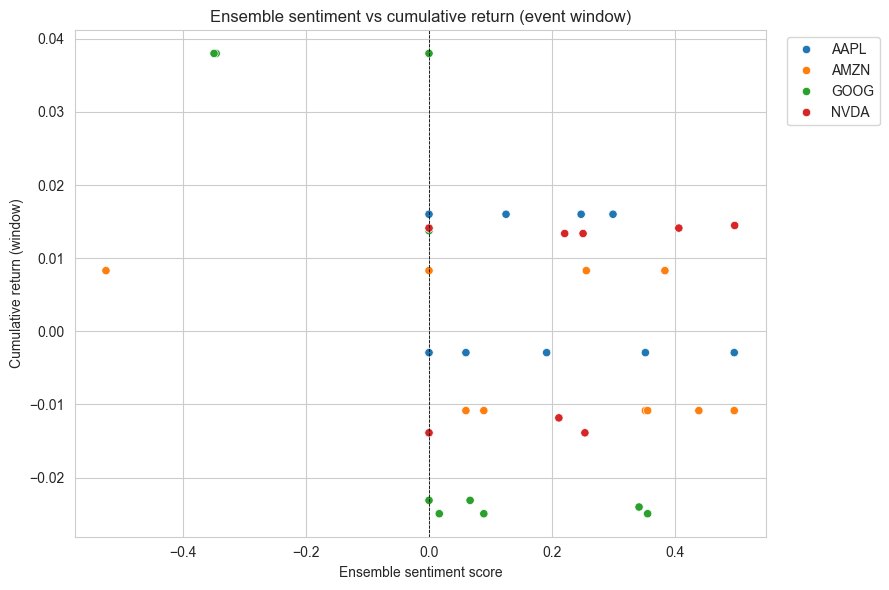

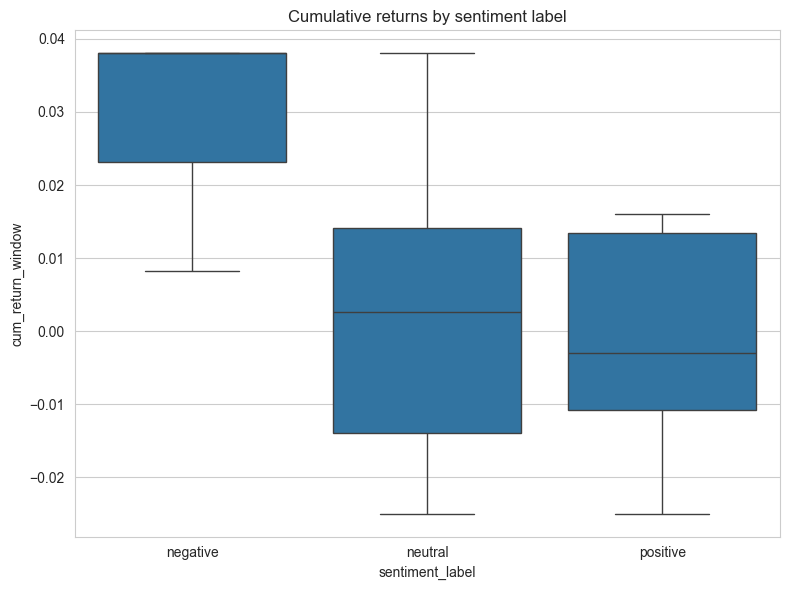

In [19]:
# Scatter: sentiment vs cum return
plt.figure(figsize=(9,6))
sns.scatterplot(data=events_df, x='ensemble_score', y='cum_return_window', hue='ticker')
plt.axvline(0, color='k', linestyle='--', linewidth=0.6)
plt.title('Ensemble sentiment vs cumulative return (event window)')
plt.xlabel('Ensemble sentiment score')
plt.ylabel('Cumulative return (window)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'sentiment_vs_cumreturn.png'))
plt.show()

# Boxplot: cum return by sentiment label
plt.figure(figsize=(8,6))
order = ['negative','neutral','positive']
sns.boxplot(data=events_df, x='sentiment_label', y='cum_return_window', order=order)
plt.title('Cumulative returns by sentiment label')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'box_cumreturn_by_label.png'))
plt.show()


## Save merged data & per-ticker summary

In [18]:
# Save results
events_df.to_csv(os.path.join(output_folder, 'events_sentiment_stock_merged.csv'), index=False)

summary = events_df.groupby('ticker').agg(
    n_events=('ensemble_score','count'),
    avg_sentiment=('ensemble_score','mean'),
    avg_cum_return=('cum_return_window','mean'),
    med_cum_return=('cum_return_window','median'),
    std_cum_return=('cum_return_window','std')
).reset_index()
summary.to_csv(os.path.join(output_folder,'summary_by_ticker.csv'), index=False)

print("Saved outputs to:", output_folder)
summary


Saved outputs to: ./output


,ticker,n_events,avg_sentiment,avg_cum_return,med_cum_return,std_cum_return
0,AAPL,10,0.176777,0.004661,-0.002907,0.009771
1,AMZN,10,0.190198,-0.003179,-0.010835,0.009883
2,GOOG,10,0.017360,-0.001726,-0.023109,0.029821
3,NVDA,10,0.183542,0.003015,0.013379,0.014112


## Strategy suggestions (starting points — backtest before trading)

- **Short-term momentum on strong signals**  
  *Hypothesis:* Strong positive article (ensemble_score > 0.2) leads to short-term positive returns. Strategy: enter long at next market open, hold for 1–5 trading days, take profit or exit on stop-loss.  
  *Risk control:* limit position size (1–2% of portfolio), account for slippage and transaction costs.

- **Protection on negative signals**  
  *Hypothesis:* Strongly negative articles (ensemble_score < -0.2) predict short-term declines. Strategy: buy protective puts or reduce exposure / short if available and permitted.

- **Combine filters to reduce false signals**  
  *Use:* publisher credibility, article frequency (multiple articles same day), confirmatory technical filters (e.g., price > 20-day MA), or avoid trading around earnings.

- **Market controls**  
  Always control for market returns (e.g., subtract SPY returns) so you are capturing idiosyncratic moves, not market-wide moves.

- **Backtesting & robustness**  
  Walk-forward backtests, transaction costs, and realistic fills are essential. Test different window sizes, sentiment thresholds, and ensemble weighting schemes.

> These are conceptual suggestions. You should convert them into a backtesting framework and measure sharpe, drawdowns, hit rate, and transaction-cost adjusted returns before any live use.


Loaded dataset shape: (1407328, 6)
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00   

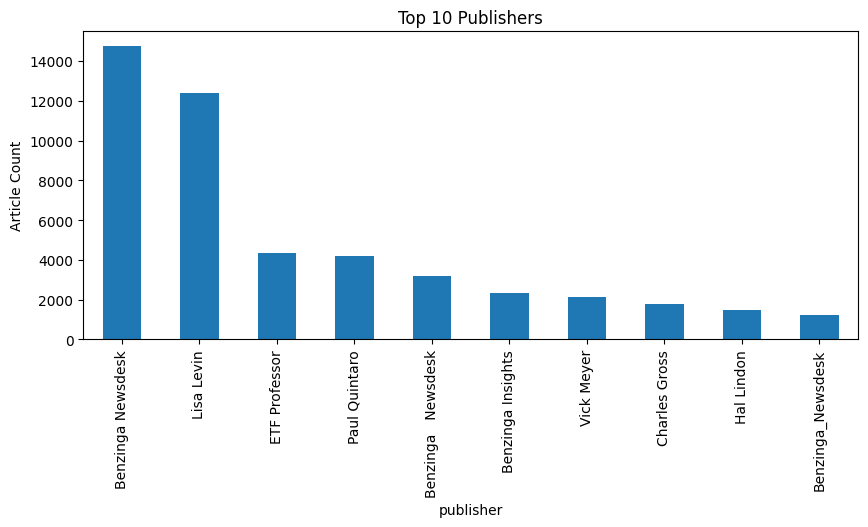


Date Range: 2011-04-27 to 2020-06-11
Total unique dates: 2528


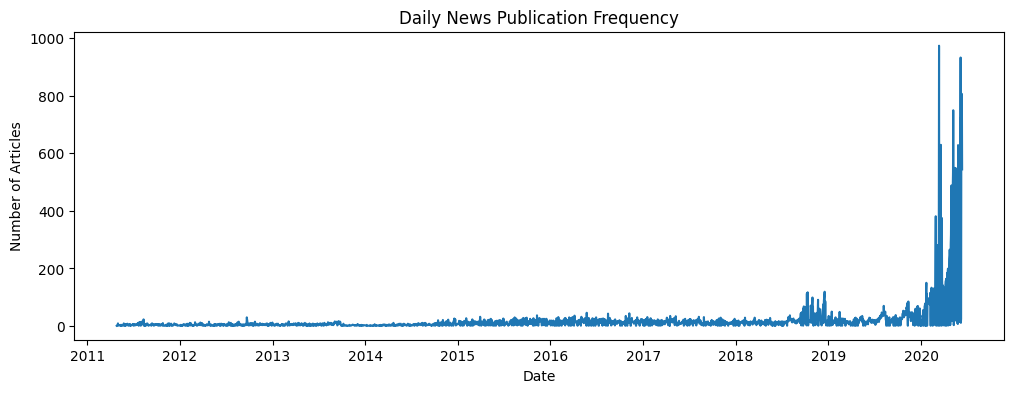


Top Keywords:
[('to', 15901), ('on', 13697), ('of', 13334), ('stocks', 12796), ('the', 11273), ('in', 11104), ('week', 8959), ('m', 8787), ('shares', 8375), ('for', 8357), ('from', 7355), ('q', 7104), ('that', 6785), ('trading', 6574), ('and', 6236), ('are', 6214), ('hit', 5898), ('eps', 5530), ('as', 5278), ('a', 5139)]


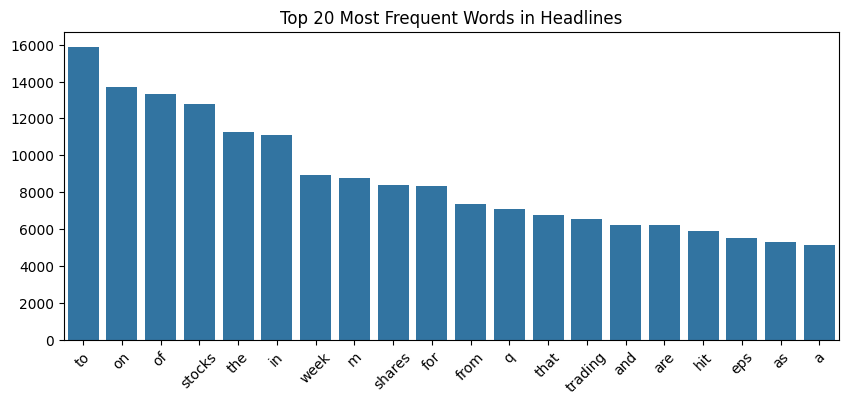


Hourly News Frequency:
hour
0       67
1       14
2       57
3       93
4     1469
5     1829
6     2476
7     5033
8     5527
9     5965
10    7669
11    5701
12    5732
13    2710
14    2075
15    1612
16    3939
17    2800
18     704
19     227
20     131
21      82
22      48
23      27
Name: count, dtype: int64


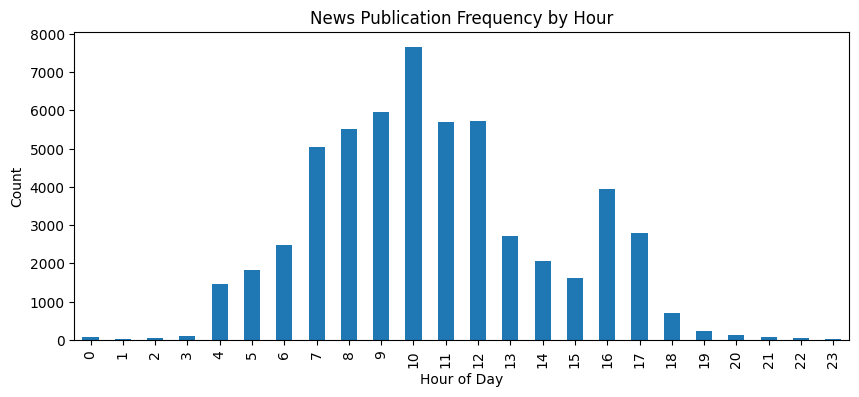


Top Publisher Domains:
publisher_domain
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64

Saved cleaned file → ../cleaned/cleaned_analyst_ratings.csv

Task 1 EDA completed successfully.


In [5]:
# ============================
# Task 1 – Minimum Essential EDA
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns
import re
from collections import Counter

# Set display options
pd.set_option('display.max_columns', None)

# -----------------------------
# LOAD NEWS DATA
# -----------------------------

news_csv = "../Data/newsData/analyst_ratings.csv"
df = pd.read_csv(news_csv)

print("Loaded dataset shape:", df.shape)
print(df.head())

# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with no headlines or dates
df = df.dropna(subset=['headline', 'date'])

# -----------------------------
# DESCRIPTIVE STATISTICS
# -----------------------------

# Headline length
df["headline_length"] = df["headline"].apply(lambda x: len(str(x).split()))

print("\nHeadline Length Statistics:")
print(df["headline_length"].describe())


# -----------------------------
# PUBLISHER ANALYSIS
# -----------------------------

publisher_counts = df["publisher"].value_counts()

print("\nTop Publishers:")
print(publisher_counts.head(10))

# Plot publisher distribution
plt.figure(figsize=(10,4))
publisher_counts.head(10).plot(kind="bar")
plt.title("Top 10 Publishers")
plt.ylabel("Article Count")
plt.show()


# -----------------------------
# PUBLICATION DATE ANALYSIS
# -----------------------------

df['date_only'] = df['date'].dt.date
daily_counts = df['date_only'].value_counts().sort_index()

print("\nDate Range:", df['date_only'].min(), "to", df['date_only'].max())
print("Total unique dates:", len(daily_counts))

# Plot daily frequency
plt.figure(figsize=(12,4))
daily_counts.plot()
plt.title("Daily News Publication Frequency")
plt.ylabel("Number of Articles")
plt.xlabel("Date")
plt.show()


# -----------------------------
# KEYWORD EXTRACTION (Topic Signals)
# -----------------------------

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df["clean_headline"] = df["headline"].apply(clean_text)

all_words = " ".join(df["clean_headline"]).split()
common_words = Counter(all_words).most_common(20)

print("\nTop Keywords:")
print(common_words)

# Simple visualization
words, counts = zip(*common_words)
plt.figure(figsize=(10,4))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words in Headlines")
plt.show()


# -----------------------------
# TIME SERIES ANALYSIS (HOURLY)
# -----------------------------

df["hour"] = df["date"].dt.hour

hourly_counts = df["hour"].value_counts().sort_index()

print("\nHourly News Frequency:")
print(hourly_counts)

plt.figure(figsize=(10,4))
hourly_counts.plot(kind="bar")
plt.title("News Publication Frequency by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.show()


# -----------------------------
# PUBLISHER DOMAIN ANALYSIS
# -----------------------------

def extract_domain(p):
    if isinstance(p, str) and "@" in p:
        return p.split("@")[-1]
    return p  # return original if not email format

df["publisher_domain"] = df["publisher"].apply(extract_domain)

domain_counts = df["publisher_domain"].value_counts()

print("\nTop Publisher Domains:")
print(domain_counts.head(10))


# -----------------------------
# SAVE CLEANED VERSION
# -----------------------------

output_path = "../cleaned/cleaned_analyst_ratings.csv"
df.to_csv(output_path, index=False)

print("\nSaved cleaned file →", output_path)
print("\nTask 1 EDA completed successfully.")


Loaded dataset shape: (1407328, 6)
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00   

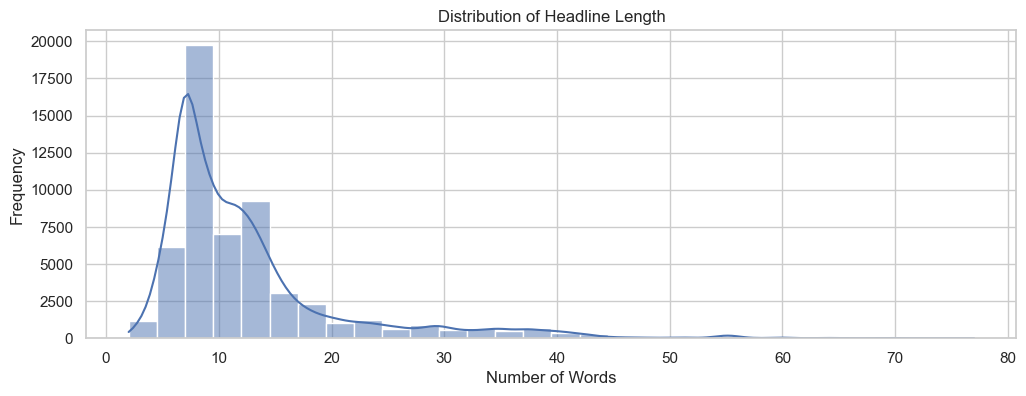


Top Publishers:
publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64


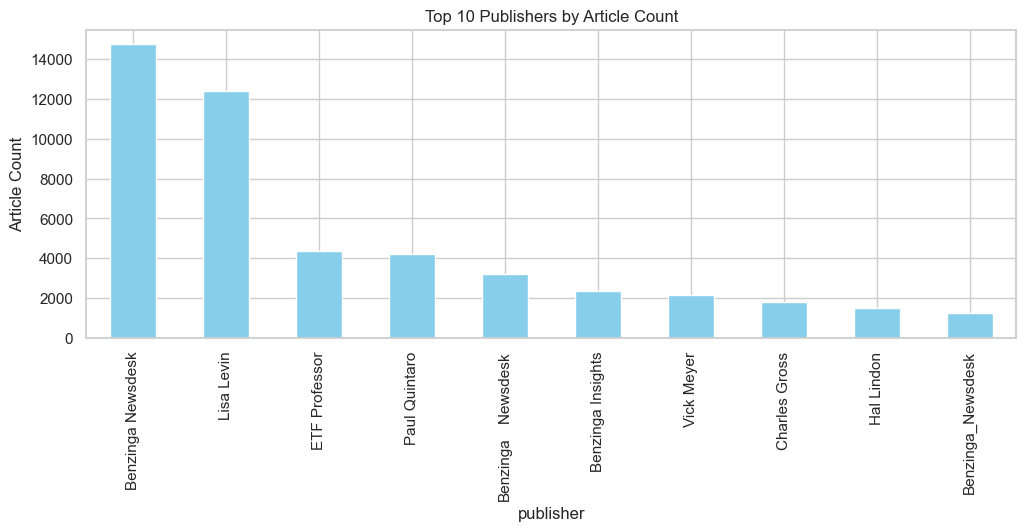


Date Range: 2011-04-27 to 2020-06-11


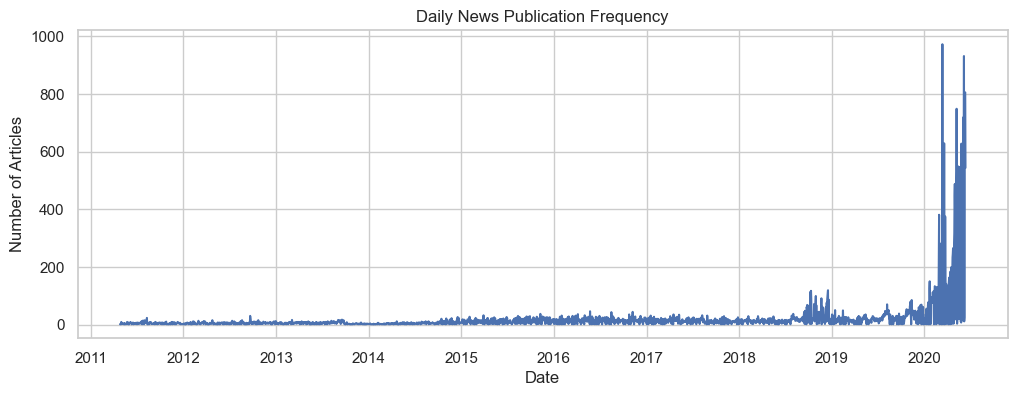


Top Keywords:
[('to', 15901), ('on', 13697), ('of', 13334), ('stocks', 12796), ('the', 11273), ('in', 11104), ('week', 8959), ('m', 8787), ('shares', 8375), ('for', 8357), ('from', 7355), ('q', 7104), ('that', 6785), ('trading', 6574), ('and', 6236), ('are', 6214), ('hit', 5898), ('eps', 5530), ('as', 5278), ('a', 5139)]


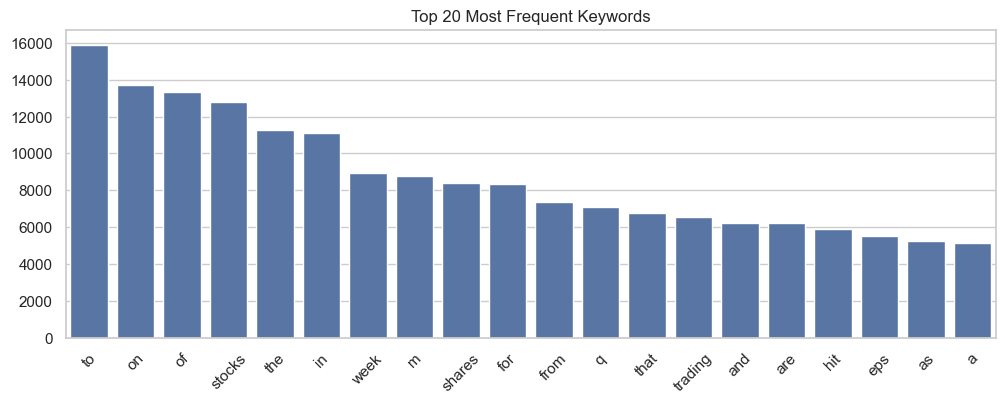


Hourly News Frequency:
hour
0       67
1       14
2       57
3       93
4     1469
5     1829
6     2476
7     5033
8     5527
9     5965
10    7669
11    5701
12    5732
13    2710
14    2075
15    1612
16    3939
17    2800
18     704
19     227
20     131
21      82
22      48
23      27
Name: count, dtype: int64


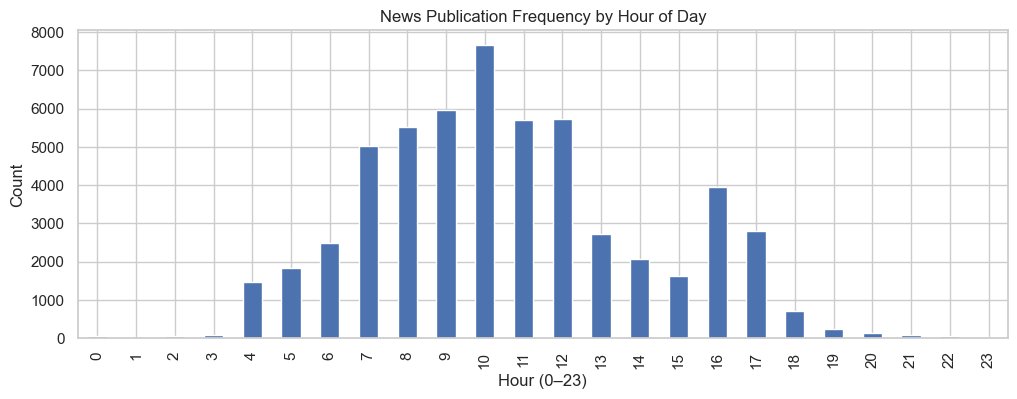


Top Publisher Domains:
publisher_domain
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64

Saved cleaned file → ../cleaned/cleaned_analyst_ratings2.csv

Task 1 EDA completed successfully.


In [10]:
# ============================
# Task 1 – Minimum Essential EDA (with visualizations)
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
from collections import Counter

# Styling
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)

# -----------------------------
# LOAD NEWS DATA
# -----------------------------

news_csv = "../Data/newsData/analyst_ratings.csv"
df = pd.read_csv(news_csv)

print("Loaded dataset shape:", df.shape)
print(df.head())

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['headline', 'date'])

# -----------------------------
# HEADLINE LENGTH ANALYSIS
# -----------------------------

df["headline_length"] = df["headline"].apply(lambda x: len(str(x).split()))

print("\nHeadline Length Summary:")
print(df["headline_length"].describe())

# Visualization: Distribution of headline length
plt.figure(figsize=(12,4))
sns.histplot(df["headline_length"], kde=True, bins=30)
plt.title("Distribution of Headline Length")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


# -----------------------------
# PUBLISHER ANALYSIS
# -----------------------------

publisher_counts = df["publisher"].value_counts()

print("\nTop Publishers:")
print(publisher_counts.head(10))

# Visualization: Top publishers
plt.figure(figsize=(12,4))
publisher_counts.head(10).plot(kind="bar", color='skyblue')
plt.title("Top 10 Publishers by Article Count")
plt.ylabel("Article Count")
plt.show()


# -----------------------------
# PUBLICATION DATE ANALYSIS
# -----------------------------

df["date_only"] = df["date"].dt.date
daily_counts = df["date_only"].value_counts().sort_index()

print("\nDate Range:", df["date_only"].min(), "to", df["date_only"].max())

# Visualization: Daily publication frequency
plt.figure(figsize=(12,4))
daily_counts.plot()
plt.title("Daily News Publication Frequency")
plt.ylabel("Number of Articles")
plt.xlabel("Date")
plt.show()


# -----------------------------
# KEYWORD EXTRACTION / TOPIC SIGNALS
# -----------------------------

def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-zA-Z\s]", "", t)
    return t

df["clean_headline"] = df["headline"].apply(clean_text)

all_words = " ".join(df["clean_headline"]).split()
common_words = Counter(all_words).most_common(20)

print("\nTop Keywords:")
print(common_words)

# Visualization: Keyword frequency
words, counts = zip(*common_words)

plt.figure(figsize=(12,4))
sns.barplot(x=list(words), y=list(counts))
plt.title("Top 20 Most Frequent Keywords")
plt.xticks(rotation=45)
plt.show()


# -----------------------------
# HOURLY FREQUENCY ANALYSIS
# -----------------------------

df["hour"] = df["date"].dt.hour

hourly_counts = df["hour"].value_counts().sort_index()
print("\nHourly News Frequency:")
print(hourly_counts)

# Visualization: Hourly distribution
plt.figure(figsize=(12,4))
hourly_counts.plot(kind="bar")
plt.title("News Publication Frequency by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Count")
plt.show()


# -----------------------------
# PUBLISHER DOMAIN ANALYSIS
# -----------------------------

def extract_domain(pub):
    if isinstance(pub, str) and "@" in pub:
        return pub.split("@")[-1]
    return pub

df["publisher_domain"] = df["publisher"].apply(extract_domain)

domain_counts = df["publisher_domain"].value_counts()

print("\nTop Publisher Domains:")
print(domain_counts.head(10))


# -----------------------------
# SAVE CLEANED OUTPUT
# -----------------------------

output_path = "../cleaned/cleaned_analyst_ratings2.csv"
df.to_csv(output_path, index=False)

print("\nSaved cleaned file →", output_path)
print("\nTask 1 EDA completed successfully.")


## Task 2 — Technical Indicators + Visualizations
#### - Loads OHLCV for AAPL, AMZN, GOOG, META, MSFT, NVDA from ./Data/yfinance_data/Data
#### - Computes SMA, EMA, RSI, MACD (prefers TA-Lib; falls back to pandas)
#### - Saves indicator CSVs to ./output and produces example visualizations
#### - Use this after merging task-1 into main and creating task-2 branch


In [6]:
# Cell: Imports & config
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

stock_folder = "../Data/yfinance_data/"   # your stock CSVs here
output_folder = "../output/task2"
os.makedirs(output_folder, exist_ok=True)

tickers = {
    'AAPL':'AAPL.csv','AMZN':'AMZN.csv','GOOG':'GOOG.csv',
    'META':'META.csv','MSFT':'MSFT.csv','NVDA':'NVDA.csv'
}

# Try import TA-Lib
use_talib = True
try:
    import talib
except Exception:
    use_talib = False
    print("TA-Lib not available — falling back to pandas/pandas_ta/pandas methods.")
    # Cell: helper functions for indicators (TA-Lib or pandas fallback)
def add_basic_indicators(df, close_col='Close', high_col='High', low_col='Low', volume_col='Volume'):
    """
    Adds SMA(20,50), EMA(20), RSI(14), MACD to df and returns df copy.
    """
    df = df.copy()
    if use_talib:
        df['SMA20'] = talib.SMA(df[close_col].values, timeperiod=20)
        df['SMA50'] = talib.SMA(df[close_col].values, timeperiod=50)
        df['EMA20'] = talib.EMA(df[close_col].values, timeperiod=20)
        df['RSI14'] = talib.RSI(df[close_col].values, timeperiod=14)
        macd, macdsignal, macdhist = talib.MACD(df[close_col].values, fastperiod=12, slowperiod=26, signalperiod=9)
        df['MACD'] = macd
        df['MACD_signal'] = macdsignal
    else:
        # SMA and EMA with pandas
        df['SMA20'] = df[close_col].rolling(20).mean()
        df['SMA50'] = df[close_col].rolling(50).mean()
        df['EMA20'] = df[close_col].ewm(span=20, adjust=False).mean()
        # RSI fallback (Wilder's method)
        delta = df[close_col].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.rolling(14).mean()
        avg_loss = loss.rolling(14).mean()
        rs = avg_gain / (avg_loss + 1e-8)
        df['RSI14'] = 100 - (100 / (1 + rs))
        # MACD fallback
        ema12 = df[close_col].ewm(span=12, adjust=False).mean()
        ema26 = df[close_col].ewm(span=26, adjust=False).mean()
        df['MACD'] = ema12 - ema26
        df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    # volatility example: rolling 20-day std of returns
    df['Return'] = df[close_col].pct_change()
    df['Vol20'] = df['Return'].rolling(20).std()
    return df
# Cell: process each ticker, save CSVs, and plot sample
for t, fname in tickers.items():
    path = os.path.join(stock_folder, fname)
    if not os.path.exists(path):
        print("Missing file:", path)
        continue
    df = pd.read_csv(path, parse_dates=['Date']).sort_values('Date').reset_index(drop=True)
    df_ind = add_basic_indicators(df)
    out_csv = os.path.join(output_folder, f"{t}_indicators.csv")
    df_ind.to_csv(out_csv, index=False)
    print(f"Saved indicators for {t} -> {out_csv}")

    # sample plot: Close + SMA20 + EMA20 + MACD (MACD on separate axis)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), sharex=True, gridspec_kw={'height_ratios':[3,1]})
    ax1.plot(df_ind['Date'], df_ind['Close'], label='Close')
    ax1.plot(df_ind['Date'], df_ind['SMA20'], label='SMA20', linewidth=0.9)
    ax1.plot(df_ind['Date'], df_ind['EMA20'], label='EMA20', linewidth=0.9)
    ax1.set_title(f"{t} Price with SMA20 & EMA20")
    ax1.legend()
    ax1.set_ylabel('Price')

    ax2.plot(df_ind['Date'], df_ind['MACD'], label='MACD')
    ax2.plot(df_ind['Date'], df_ind['MACD_signal'], label='MACD signal', linestyle='--', linewidth=0.9)
    ax2.set_ylabel('MACD')
    ax2.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"{t}_indicators_plot.png"))
    plt.close(fig)



Saved indicators for AAPL -> ../output/task2\AAPL_indicators.csv
Saved indicators for AMZN -> ../output/task2\AMZN_indicators.csv
Saved indicators for GOOG -> ../output/task2\GOOG_indicators.csv
Saved indicators for META -> ../output/task2\META_indicators.csv
Saved indicators for MSFT -> ../output/task2\MSFT_indicators.csv
Saved indicators for NVDA -> ../output/task2\NVDA_indicators.csv


#### Task 3 — Sentiment vs. Price Movement
#### - Loads cleaned news CSV (use the same cleaned file you created)
#### - Computes TextBlob + VADER sentiment per headline, aggregates daily
#### - Loads indicator CSVs from Task 2, computes daily returns
#### - Aligns dates, computes Pearson correlation, rolling correlation, scatterplots
#### - Runs a simple OLS regression showing sentiment vs short-term returns
